# Importações

In [1]:
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

from sklearn.preprocessing import StandardScaler as Scaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report

from sklearn.neural_network import MLPClassifier

%matplotlib inline

plt.rcParams["figure.figsize"] = (16,10)

# Configurar dataset

### Baixar dados 

**Caso não seja possível baixar os dados do link no dropbox, por favor, baixar no link:**
https://www.kaggle.com/ealaxi/paysim1

In [2]:
!wget -O fraud.csv https://www.dropbox.com/s/47hd95t7n8hhlgz/fraude.csv?dl=0

--2021-09-04 17:31:20--  https://www.dropbox.com/s/47hd95t7n8hhlgz/fraude.csv?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.80.18, 2620:100:6035:18::a27d:5512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.80.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/47hd95t7n8hhlgz/fraude.csv [following]
--2021-09-04 17:31:20--  https://www.dropbox.com/s/raw/47hd95t7n8hhlgz/fraude.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucd0b5364edb71a5bc40de593bdc.dl.dropboxusercontent.com/cd/0/inline/BVgdYzL0vZ8g6Og3tJz1VRgtw6qLDJy-0rlOB0JM6tDAa6nVK35OecM9nDIT40aLDyrpLndrK-DxFyn5hOqmliCmsuB7QzgcJtwcjyPvXthgUusgKxRJOKPLTWaov_aCVJgNVPReBGLgXjtex-HhMfuG/file# [following]
--2021-09-04 17:31:21--  https://ucd0b5364edb71a5bc40de593bdc.dl.dropboxusercontent.com/cd/0/inline/BVgdYzL0vZ8g6Og3tJz1VRgtw6qLDJy-0rlOB0JM6tDAa6nVK35OecM9nDIT40aLDyrpLndrK-DxFyn5hOqmliCm

In [342]:
dataset_path = "fraud.csv"

### Ler CSV

In [352]:
df = pd.read_csv(dataset_path)

# 3 - Preparação dos dados

## 3.1 - Normalização logarítimica

In [353]:
df['amount'].describe()

count    6.362620e+06
mean     1.798619e+05
std      6.038582e+05
min      0.000000e+00
25%      1.338957e+04
50%      7.487194e+04
75%      2.087215e+05
max      9.244552e+07
Name: amount, dtype: float64

In [354]:
df['oldbalanceOrg'].describe()

count    6.362620e+06
mean     8.338831e+05
std      2.888243e+06
min      0.000000e+00
25%      0.000000e+00
50%      1.420800e+04
75%      1.073152e+05
max      5.958504e+07
Name: oldbalanceOrg, dtype: float64

In [355]:
df['newbalanceOrig'].describe()

count    6.362620e+06
mean     8.551137e+05
std      2.924049e+06
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.442584e+05
max      4.958504e+07
Name: newbalanceOrig, dtype: float64

In [356]:
df['oldbalanceDest'].describe()

count    6.362620e+06
mean     1.100702e+06
std      3.399180e+06
min      0.000000e+00
25%      0.000000e+00
50%      1.327057e+05
75%      9.430367e+05
max      3.560159e+08
Name: oldbalanceDest, dtype: float64

In [357]:
df['newbalanceDest'].describe()

count    6.362620e+06
mean     1.224996e+06
std      3.674129e+06
min      0.000000e+00
25%      0.000000e+00
50%      2.146614e+05
75%      1.111909e+06
max      3.561793e+08
Name: newbalanceDest, dtype: float64

Todos tem como valor mínimo 0. log 0 é impossível, logo deve-se mudar os valores para retirar o 0 antes de mudar a escala para logarítmica.

In [358]:
log_list = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

for i in log_list:
    df[i] = (0.1+df[i])#Como existem valores iguais a 0, é preciso tirá-los para fazer o log
    df[i] = np.log(df[i])

## 3.2 - Separação dos dados
É preciso separar os dados em treino, teste e validação antes de normalizar os dados, caso contrário ocorrerá vazamento de dados.
60% dos dados serão usados no grupo de treinamento, 25% no grupo de validação e 15% no grupo de teste.

### 3.2.1 - Separa em treino, teste e validacao

In [359]:
tamanho_df = df.shape[0]
colunas_y = ["isFraud"]
colunas_nao_x = ["isFraud", "isFlaggedFraud"]
colunas_x = [coluna for coluna in df.columns if coluna not in colunas_nao_x]

# Treino 
fim_treino = round(tamanho_df * 0.6)

treino = df.loc[0:fim_treino,:]
fraudes_treino = treino[treino['isFraud'] == 1]
legitimo_treino = treino[treino['isFraud'] == 0]
legitimo_treino = legitimo_treino.sample(n=fraudes_treino.shape[0], random_state=1)
treino_balanceado = pd.concat([legitimo_treino, fraudes_treino], axis= 0)
x_treino_balanceado = treino_balanceado.loc[:, colunas_x]
y_treino_balanceado = treino_balanceado.loc[:, colunas_y]

x_treino = df.loc[0:fim_treino,colunas_x]
y_treino = df.loc[0:fim_treino, colunas_y]


# Validacao
fim_validacao = round(tamanho_df * (0.6 + 0.25))

validacao = df.loc[fim_treino:fim_validacao,:]
fraudes_validacao = validacao[validacao['isFraud'] == 1]
legitimo_validacao = validacao[validacao['isFraud'] == 0]
legitimo_validacao = legitimo_validacao.sample(n=fraudes_validacao.shape[0], random_state=1)
validacao_balanceado = pd.concat([legitimo_validacao, fraudes_validacao], axis= 0)
x_validacao_balanceado = validacao_balanceado.loc[:, colunas_x]
y_validacao_balanceado = validacao_balanceado.loc[:, colunas_y]

x_validacao = df.loc[fim_treino:fim_validacao, colunas_x]
y_validacao =  df.loc[fim_treino:fim_validacao, colunas_y]

# Teste

teste = df.loc[fim_validacao:tamanho_df,:]
fraudes_teste = teste[teste['isFraud'] == 1]
legitimo_teste = teste[teste['isFraud'] == 0]
legitimo_teste = legitimo_teste.sample(n=fraudes_teste.shape[0], random_state=1)
teste_balanceado = pd.concat([legitimo_teste, fraudes_teste], axis= 0)
x_teste_balanceado = teste_balanceado.loc[:, colunas_x]
y_teste_balanceado = teste_balanceado.loc[:, colunas_y]

x_teste =  df.loc[fim_validacao:tamanho_df , colunas_x]
y_teste = df.loc[fim_validacao:tamanho_df, colunas_y]

In [360]:
print(x_treino.shape)
print(x_validacao.shape)
print(x_teste.shape)

print(x_treino_balanceado.shape)
print(y_treino_balanceado.shape)
print(x_validacao_balanceado.shape)
print(y_validacao_balanceado.shape)
print(x_teste_balanceado.shape)
print(y_teste_balanceado.shape)

(3817573, 9)
(1590656, 9)
(954393, 9)
(6378, 9)
(6378, 1)
(2032, 9)
(2032, 1)
(8016, 9)
(8016, 1)


## 3.3 - Padronização dos dados
Apenas variáveis contínuas e discretas devem ser padronizadas.

In [361]:
colunas_scaler = ["amount", "oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "newbalanceDest"]
scaler = Scaler()

x_treino_balanceado[colunas_scaler] = scaler.fit_transform(x_treino_balanceado[colunas_scaler])

x_validacao_balanceado[colunas_scaler] = scaler.transform(x_validacao_balanceado[colunas_scaler])

x_teste_balanceado[colunas_scaler] = scaler.transform(x_teste_balanceado[colunas_scaler])

In [362]:
scaler = Scaler()

x_treino[colunas_scaler] = scaler.fit_transform(x_treino[colunas_scaler])

x_validacao[colunas_scaler] = scaler.transform(x_validacao[colunas_scaler])

x_teste[colunas_scaler] = scaler.transform(x_teste[colunas_scaler])

In [363]:
x_treino.head(2)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest
0,1,PAYMENT,-0.878175,C1231006815,0.803964,1.054779,M1979787155,-1.156928,-1.256277
1,1,PAYMENT,-1.789201,C1666544295,0.492848,0.771232,M2044282225,-1.156928,-1.256277


In [364]:
x_validacao_balanceado.head(2)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest
3998125,298,TRANSFER,0.746727,C275945467,-2.060802,-0.531852,C1644909153,1.385417,1.151396
4658759,330,PAYMENT,-1.519311,C62030761,0.422256,1.770014,M182672016,-0.920817,-1.118828


## 3.4 - Tratamento de variáveis categóricas

### 3.4.1 - Corrigindo variáveis nameOrig e nameDest

In [365]:
x_treino.loc[x_treino['nameDest'].astype(str).str[0] == 'C', 'nameDest'] = 'C'
x_treino.loc[x_treino['nameDest'].astype(str).str[0] == 'M', 'nameDest'] = 'M'
x_treino_balanceado.loc[x_treino_balanceado['nameDest'].astype(str).str[0] == 'C', 'nameDest'] = 'C'
x_treino_balanceado.loc[x_treino_balanceado['nameDest'].astype(str).str[0] == 'M', 'nameDest'] = 'M'

x_validacao.loc[x_validacao['nameDest'].astype(str).str[0] == 'C', 'nameDest'] = 'C'
x_validacao.loc[x_validacao['nameDest'].astype(str).str[0] == 'M', 'nameDest'] = 'M'
x_validacao_balanceado.loc[x_validacao_balanceado['nameDest'].astype(str).str[0] == 'C', 'nameDest'] = 'C'
x_validacao_balanceado.loc[x_validacao_balanceado['nameDest'].astype(str).str[0] == 'M', 'nameDest'] = 'M'

x_teste.loc[x_teste['nameDest'].astype(str).str[0] == 'C', 'nameDest'] = 'C'
x_teste.loc[x_teste['nameDest'].astype(str).str[0] == 'M', 'nameDest'] = 'M'
x_teste_balanceado.loc[x_teste_balanceado['nameDest'].astype(str).str[0] == 'C', 'nameDest'] = 'C'
x_teste_balanceado.loc[x_teste_balanceado['nameDest'].astype(str).str[0] == 'M', 'nameDest'] = 'M'

In [366]:
x_treino.loc[x_treino['nameOrig'].astype(str).str[0] == 'C', 'nameOrig'] = 'C'
x_treino_balanceado.loc[x_treino_balanceado['nameOrig'].astype(str).str[0] == 'C', 'nameOrig'] = 'C'

x_validacao.loc[x_validacao['nameOrig'].astype(str).str[0] == 'C', 'nameOrig'] = 'C'
x_validacao_balanceado.loc[x_validacao_balanceado['nameOrig'].astype(str).str[0] == 'C', 'nameOrig'] = 'C'

x_teste.loc[x_teste['nameOrig'].astype(str).str[0] == 'C', 'nameOrig'] = 'C'
x_teste_balanceado.loc[x_teste_balanceado['nameOrig'].astype(str).str[0] == 'C', 'nameOrig'] = 'C'

In [367]:
x_treino.head(10)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest
0,1,PAYMENT,-0.878175,C,0.803964,1.054779,M,-1.156928,-1.256277
1,1,PAYMENT,-1.789201,C,0.492848,0.771232,M,-1.156928,-1.256277
2,1,TRANSFER,-3.066135,C,-0.219784,-0.862883,C,-1.156928,-1.256277
3,1,CASH_OUT,-3.066135,C,-0.219784,-0.862883,C,0.406175,-1.256277
4,1,PAYMENT,-0.784832,C,0.593151,0.829336,M,-1.156928,-1.256277
5,1,PAYMENT,-1.004149,C,0.631945,0.887343,M,-1.156928,-1.256277
6,1,PAYMENT,-1.056287,C,0.815024,1.067389,M,-1.156928,-1.256277
7,1,PAYMENT,-1.001081,C,0.809106,1.061259,M,-1.156928,-1.256277
8,1,PAYMENT,-1.367800,C,0.182698,-0.862883,M,-1.156928,-1.256277
9,1,DEBIT,-1.213123,C,0.593748,0.855737,C,0.493113,0.405974


### 3.4.2 - OneHotEncoder

In [368]:
onehotencoder_ = ColumnTransformer(transformers=[('OneHot', OneHotEncoder(), [1,3,6])], remainder='passthrough')

x_treino = onehotencoder_.fit_transform(x_treino)
x_treino_balanceado = onehotencoder_.fit_transform(x_treino_balanceado)
x_validacao = onehotencoder_.fit_transform(x_validacao)
x_validacao_balanceado = onehotencoder_.fit_transform(x_validacao_balanceado)
x_teste = onehotencoder_.fit_transform(x_teste)
x_teste_balanceado = onehotencoder_.fit_transform(x_teste_balanceado)

In [369]:
print(x_treino.shape)
print(x_validacao.shape)
print(x_teste.shape)

print(x_treino_balanceado.shape)
print(x_validacao_balanceado.shape)
print(x_teste_balanceado.shape)

(3817573, 14)
(1590656, 14)
(954393, 14)
(6378, 14)
(2032, 14)
(8016, 14)


## 3.5 - Ajustes finais

In [370]:
y_treino = y_treino.to_numpy()
y_treino_balanceado = y_treino_balanceado.to_numpy()

y_validacao = y_validacao.to_numpy()
y_validacao_balanceado = y_validacao_balanceado.to_numpy()

y_teste = y_teste.to_numpy()
y_teste_balanceado = y_teste_balanceado.to_numpy()

In [371]:
y_treino = y_treino.ravel()
y_treino_balanceado = y_treino_balanceado.ravel()

y_validacao = y_validacao.ravel()
y_validacao_balanceado = y_validacao_balanceado.ravel()

y_teste = y_teste.ravel()
y_teste_balanceado = y_teste_balanceado.ravel()

# 4 - Classificadores

## 4.1 - Regressão Logística

In [372]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

### 4.1.1 - Dados Balanceados

In [373]:
lr = LogisticRegressionCV(cv=5, max_iter=1500)

In [374]:
lr.fit(x_treino_balanceado, y_treino_balanceado)

LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=1500, multi_class='auto', n_jobs=None,
                     penalty='l2', random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

In [375]:
lr.score(x_teste, y_teste)

0.8414741097220956

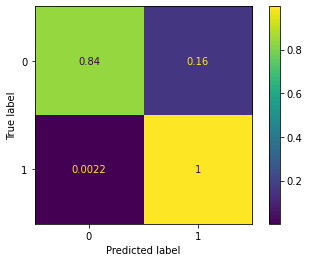

In [376]:
plot_confusion_matrix(lr, x_teste, y_teste, normalize='true')
plt.show()

#### Respondendo perguntas

In [377]:
y_predict = lr.predict(x_teste)

In [378]:
fraude_detectada = []
fraude_real = []
legitimo_detectado = []
legitimo_real = []
for i in range(len(y_predict)):
    if y_predict[i]==y_teste[i] and y_teste[i]==1:
        fraude_real.append(fim_validacao+i)
    if y_predict[i]==1 and y_teste[i]==0:
        fraude_detectada.append(fim_validacao+i)
    if y_predict[i]==0 and y_teste[i]==1:
        legitimo_detectado.append(fim_validacao+i)
    if y_predict[i]==y_teste[i] and y_teste[i]==0:
        legitimo_real.append(fim_validacao+i)

In [379]:
df = pd.read_csv(dataset_path)

##### Lucro 100% de acertos

In [380]:
df_100 = df.loc[fim_validacao:tamanho_df,:]
df_100_fraude = df_100[df_100['isFraud']==1]
df_100_legitimo = df_100[df_100['isFraud']==0]

In [381]:
lucro_100_porcento = df_100_fraude['amount'].sum()/4 + df_100_legitimo['amount'].sum()/50

In [382]:
lucro_100_porcento

4662745125.904598

##### Prejuízo falha do modelo

In [383]:
df_falha = df.loc[fim_validacao:tamanho_df,:]
df_falha_fraude = df_falha[df_falha['isFraud']==1]
df_falha_legitimo = df_falha[df_falha['isFraud']==0]

In [385]:
prejuizo_falha = -(df_falha_fraude['amount'].sum() + df_falha_legitimo['amount'].sum()/20)

In [386]:
prejuizo_falha

-14028146116.781496

##### Lucro real do modelo

In [388]:
df_fraude_real = df.iloc[fraude_real]
df_fraude_detectada = df.iloc[fraude_detectada]
df_legitimo_detectado = df.iloc[legitimo_detectado]
df_legitimo_real = df.iloc[legitimo_real]

In [389]:
soma_fraude_real = df_fraude_real['amount'].sum()
soma_fraude_detectada = df_fraude_detectada['amount'].sum()
soma_legitimo_detectado = df_legitimo_detectado['amount'].sum()
soma_legitimo_real = df_legitimo_real['amount'].sum()

In [390]:
lucro_modelo = (soma_fraude_real/4) + (soma_legitimo_real/50) - (soma_fraude_detectada/20) - soma_erro_deteccao

In [391]:
lucro_modelo

2313195115.398598

### 4.1.2 - Dados não balanceados

In [392]:
lr = LogisticRegression()

In [393]:
lr.fit(x_treino,y_treino)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [394]:
lr.score(x_teste, y_teste)

0.9978478467465709

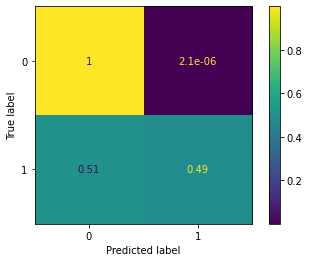

In [395]:
plot_confusion_matrix(lr, x_teste, y_teste, normalize='true')
plt.show()

## 4.2 - Rede Neural MLP

### Treinamento

In [325]:
plt.rcParams["figure.figsize"] = (6,4)
dict_modelos = dict()
tamanhos_rede = [1,2,5,10,15,20,25,30]
#tamanhos_rede = [10]

for numero_neuronio in tamanhos_rede:
    
    modelo_MLP = MLPClassifier( hidden_layer_sizes = numero_neuronio, activation = 'relu' , 
                               solver = 'adam' , 
                               alpha = 0.0001 , 
                               batch_size = 'auto' , 
                               learning_rate = 'constant' , 
                               learning_rate_init = 0.01 , 
                               power_t = 0.5 , 
                               max_iter = 500 , 
                               shuffle = True , 
                               random_state = None , 
                               tol= 0.0001 , 
                               verbose = False , 
                               warm_start = False , 
                               momentum = 0.9 , 
                               nesterovs_momentum = True , 
                               early_stopping = False , 
                               validation_fraction = 0.1 , 
                               beta_1 = 0.9, 
                               beta_2 = 0.999 , 
                               epsilon = 1e-08 , 
                               n_iter_no_change = 10 , 
                               max_fun = 15000)
    
    modelo_MLP.fit(np.array(x_treino_balanceado), np.array(y_treino_balanceado))
    
    
    dict_modelos[f"numero_neuronio_{numero_neuronio}"] = modelo_MLP

In [326]:
def mostra_resultados_modelo(dict_modelos, numero_neuronio):   
    """ Retorna a matriz de confusao dos dados de treino e dos dados de teste"""
    
    print(f"--- Modelo com {numero_neuronio} Neuronios ---")
    modelo_MLP = dict_modelos[f"numero_neuronio_{numero_neuronio}"] 

    plot_confusion_matrix(modelo_MLP, np.array(x_validacao), 
                          np.array(y_validacao), 
                          normalize='true')  
    
    plot_confusion_matrix(modelo_MLP, np.array(x_teste), 
                          np.array(y_teste), 
                          normalize='true')

--- Modelo com 1 Neuronios ---


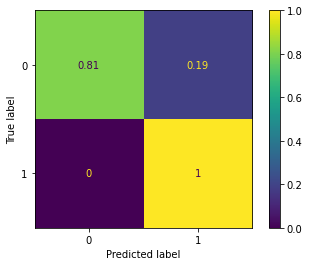

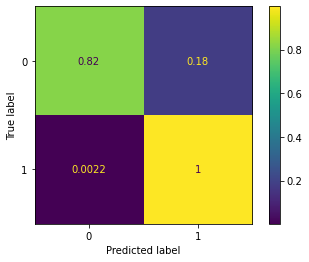

In [327]:
mostra_resultados_modelo(dict_modelos, 1)

--- Modelo com 2 Neuronios ---


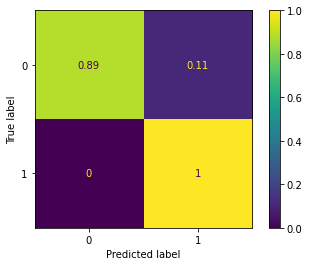

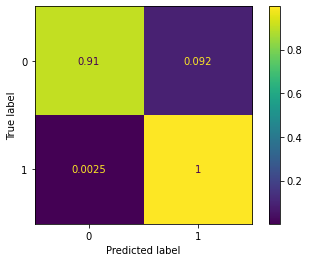

In [328]:
mostra_resultados_modelo(dict_modelos, 2)

--- Modelo com 5 Neuronios ---


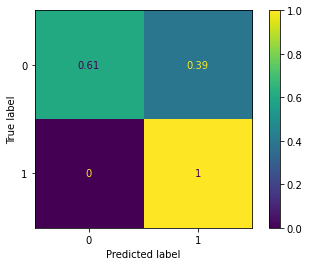

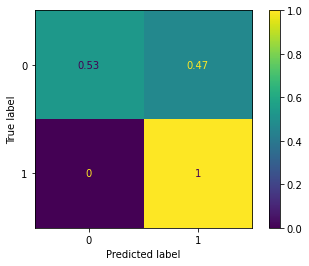

In [329]:
mostra_resultados_modelo(dict_modelos, 5)

--- Modelo com 10 Neuronios ---


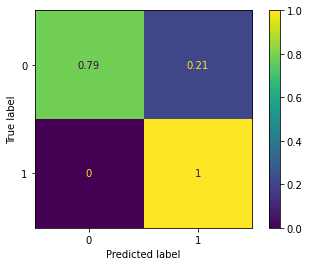

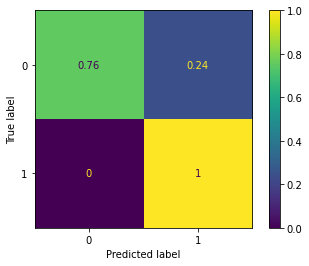

In [330]:
mostra_resultados_modelo(dict_modelos, 10)

--- Modelo com 15 Neuronios ---


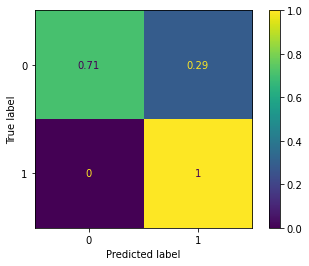

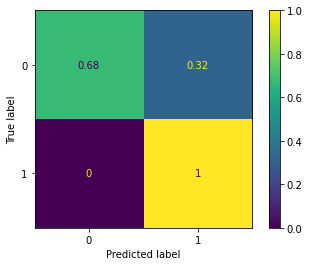

In [331]:
mostra_resultados_modelo(dict_modelos, 15)

--- Modelo com 20 Neuronios ---


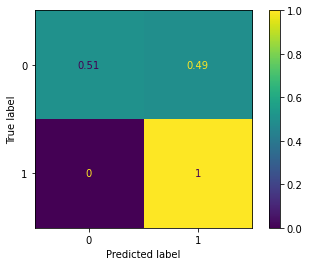

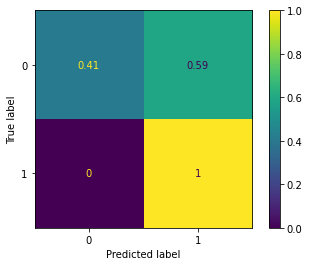

In [332]:
mostra_resultados_modelo(dict_modelos, 20)

--- Modelo com 25 Neuronios ---


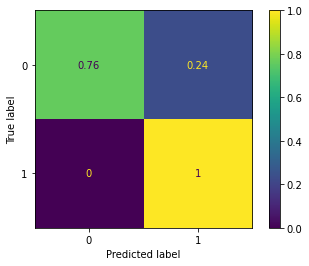

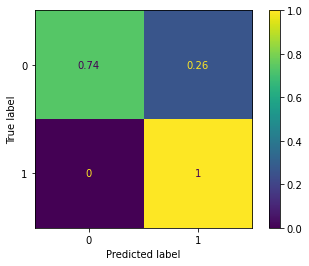

In [333]:
mostra_resultados_modelo(dict_modelos, 25)

--- Modelo com 30 Neuronios ---


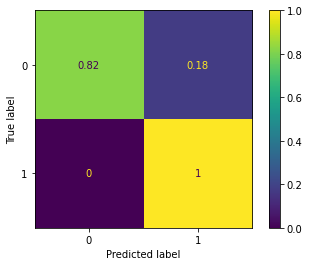

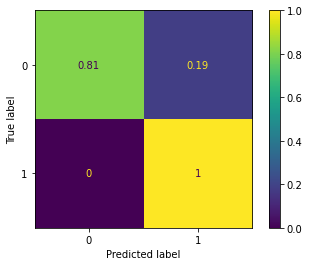

In [334]:
mostra_resultados_modelo(dict_modelos, 30)

In [337]:
dict_modelos[f"numero_neuronio_2"].score(x_teste, y_teste)

0.9084685239728288

### Melhor modelo encontrado
Salvamos na pasta notebooks no github um arquivo chamado modelo_MLP que armazena os dados do melhor modelo que conseguimos treinar. Para carregá-lo, caso já não esteja na mesma pasta que esse notebook, adicione ele à mesma pasta.

In [338]:
#Salva o modelo
pickle.dump(dict_modelos[f"numero_neuronio_2"] , open("modelo_MLP_2", 'wb'))

In [396]:
# Lê o modelo
modelo_MLP = pickle.load(open("modelo_MLP_2", 'rb'))
dict_modelos = dict()
dict_modelos["numero_neuronio_30"] = modelo_MLP

In [397]:
def mostra_resultados_modelo(dict_modelos, numero_neuronio):   
    """ Retorna a matriz de confusao dos dados de treino e dos dados de teste"""
    
    print(f"--- Modelo com {numero_neuronio} Neuronios ---")
    modelo_MLP = dict_modelos[f"numero_neuronio_{numero_neuronio}"] 
    
    plot_confusion_matrix(modelo_MLP, np.array(x_validacao), 
                          np.array(y_validacao), 
                          normalize='true')  
    
    plot_confusion_matrix(modelo_MLP, np.array(x_teste), 
                          np.array(y_teste), 
                          normalize='true')

--- Modelo com 30 Neuronios ---


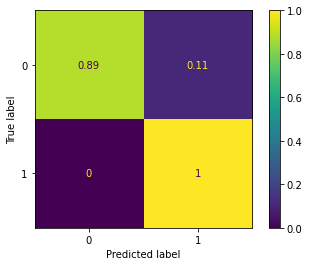

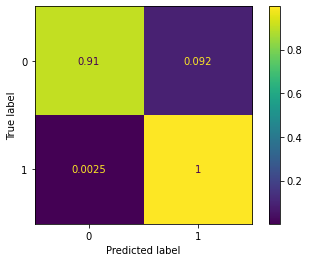

In [398]:
mostra_resultados_modelo(dict_modelos, 30)